In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import pmdarima as pm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.backends.backend_pdf as pdf
from statsmodels.tsa.x13 import x13_arima_analysis
plt.style.use("seaborn-pastel")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13436\4188670369.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-pastel")


# 1. VARIABLES

## 1.1. Importamos Datos

In [2]:
#Definimos directorio de trabajo
file="C:/Users/Usuario/OneDrive/Escritorio/3ro GANE/Indice de confianza del consumidor/Calculo"

# Nombres de los archivos Excel
nombres = ["com", "csh", "exp","hip", "hot", "icn","imp", "ipd", "ipnd", "ocup", "viv"]

# Diccionario para almacenar los DataFrames
diccionario = {}

# Iterar sobre los nombres de los archivos Excel y crear variables separadas
for nombre in nombres:
    # Leer el archivo Excel correspondiente
    datos = f"{nombre}.xlsx"
    diccionario[nombre] = pd.read_excel(datos)
    # Crear una variable separada para cada serie de datos
    exec(f"{nombre} = diccionario[nombre]")
    # Indexar la variable serie fecha
    eval(f"{nombre}").set_index("fecha", inplace=True)
    
variables=[com, csh, exp, hip, hot, icn, imp, ipd, ipnd, ocup, viv]
    
# Iterar sobre los nombres de los archivos Excel y mostrar las primeras filas de cada serie
for variable, nombre in zip(variables, nombres):
    print(nombre)
    print(variable.head())
    print("\n")

com
                esp      ara     esp_des     ara_des
fecha                                               
2004-01-01  102.753  107.053  102.905639  106.609813
2004-02-01  102.202  105.029  103.263518  105.700129
2004-03-01  102.486  106.461  103.329334  107.271676
2004-04-01  103.135  108.378  103.718030  108.429405
2004-05-01  103.184  106.458  103.782403  107.081467


csh
              esp    ara    esp_des    ara_des
fecha                                         
2008-01-01  12.50  12.00  13.410544  13.241642
2008-04-01  12.79  13.10  12.779703  12.958431
2008-07-01  13.76  13.36  13.516684  13.154107
2008-10-01  14.27  14.30  13.486784  13.289761
2009-01-01  12.80  12.15  13.845314  13.507921


exp
                  esp_des  ara_des
fecha                             
1970-01-01  453228.428395      NaN
1970-02-01  466001.392494      NaN
1970-03-01  518868.003001      NaN
1970-04-01  530028.003509      NaN
1970-05-01  537065.931163      NaN


hip
                 esp     ara     

## 1.2. Determinamos rango temporal

In [3]:
#Como se observa en la salida anterior, el período de estudio será: 2008M01-2023M09
com=com.loc["2009-01-01":"2023-09-01"]
exp=exp.loc["2009-01-01":"2023-09-01"]
hip=hip.loc["2009-01-01":"2023-09-01"]
hot=hot.loc["2009-01-01":"2023-09-01"]
icn=icn.loc["2009-01-01":"2023-09-01"]
viv=viv.loc["2009-01-01":"2023-09-01"]
imp=imp.loc["2009-01-01":"2023-09-01"]
ipd=ipd.loc["2009-01-01":"2023-09-01"]
ipnd=ipnd.loc["2009-01-01":"2023-09-01"]
viv=viv.loc["2009-01-01":"2023-09-01"]
csh=csh.loc["2009":"2023"]
ocup=ocup.loc["2009":"2023"]

## 1.3. Interpolamos series trimestrales

In [4]:
# Analizamos correlaciones:
namesx = ["com", "ipnd", "hot"]
namesy = ["csh", "ocup"]
x = [com, ipnd, hot]
y = [csh, ocup]

for vary, namey in zip(y, namesy):
    for varx, namex in zip(x, namesx):
        inter = np.corrcoef(varx, vary)[0, 1]
        print({f"{namex}-{namey}": inter})

{'com-csh': 0.9724802042820496}
{'ipnd-csh': 0.9109792965146408}
{'hot-csh': 0.9937870867906808}
{'com-ocup': 0.9724802042820496}
{'ipnd-ocup': 0.9109792965146408}
{'hot-ocup': 0.9937870867906808}


### 1.3.1. Coste laboral por hora efectiva

In [5]:
# Definimos variables a las variables independientes
M=com.index
y1 = pd.Series(csh["esp"].values.flatten().repeat(3)[:len(M)], index=M)
x1=pd.concat([com["esp_des"].loc["2009":"2023"], ipnd["esp_des"].loc["2009":"2023"], hot["esp_des"].loc["2009":"2023"]], axis=1)

# Ajustar el modelo
mod1 = sm.OLS(y1, sm.add_constant(x1)).fit()

# Realizar predicciones
pred1 = mod1.get_prediction(exog=sm.add_constant(x1))

# Crear DataFrame con los resultados
esp1 = pd.DataFrame({'esp_des': pred1.predicted_mean}, index=M)

In [6]:
# Definimos variables a las variables independientes
M=com.index
y2 = pd.Series(csh["ara"].values.flatten().repeat(3)[:len(M)], index=M)
x2=pd.concat([com["ara_des"].loc["2009":"2023"], ipnd["ara_des"].loc["2009":"2023"], hot["ara_des"].loc["2009":"2023"]], axis=1)

# Ajustar el modelo
mod2 = sm.OLS(y2, sm.add_constant(x2)).fit()

# Realizar predicciones
pred2 = mod2.get_prediction(exog=sm.add_constant(x2))

# Crear DataFrame con los resultados
ara2 = pd.DataFrame({'ara_des': pred2.predicted_mean}, index=M)

#Unimos resultaso:
cshm=pd.concat([esp1,ara2], axis=1)

# Mostrar los resultados
print(cshm)

              esp_des    ara_des
fecha                           
2009-01-01  15.618252  15.017521
2009-02-01  15.799854  14.984631
2009-03-01  15.473860  14.972444
2009-04-01  15.351104  14.885033
2009-05-01  15.337036  14.815107
...               ...        ...
2023-05-01  15.702700  14.777977
2023-06-01  15.859644  14.782391
2023-07-01  15.822235  14.789335
2023-08-01  15.681181  14.789795
2023-09-01  15.636362  14.681947

[177 rows x 2 columns]


### 1.3.2. Número de ocupados

In [7]:
# Definimos variables a las variables independientes
M=com.index
y3 = pd.Series(ocup["esp"].values.flatten().repeat(3)[:len(M)], index=M)
x3=pd.concat([com["esp_des"].loc["2009":"2023"], ipnd["esp_des"].loc["2009":"2023"], hot["esp_des"].loc["2009":"2023"]], axis=1)

# Ajustar el modelo
mod3 = sm.OLS(y3, sm.add_constant(x3)).fit()

# Realizar predicciones
pred3 = mod3.get_prediction(exog=sm.add_constant(x3))

# Crear DataFrame con los resultados
esp3 = pd.DataFrame({'esp_des': pred3.predicted_mean}, index=M)

In [8]:
# Definimos variables a las variables independientes
M=com.index
y4 = pd.Series(ocup["ara"].values.flatten().repeat(3)[:len(M)], index=M)
x4=pd.concat([com["ara_des"].loc["2009":"2023"], ipnd["ara_des"].loc["2009":"2023"], hot["ara_des"].loc["2009":"2023"]], axis=1)

# Ajustar el modelo
mod4 = sm.OLS(y4, sm.add_constant(x4)).fit()

# Realizar predicciones
pred4 = mod4.get_prediction(exog=sm.add_constant(x4))

# Crear DataFrame con los resultados
ara4 = pd.DataFrame({'ara_des': pred4.predicted_mean}, index=M)

#Unimos resultaso:
ocupm=pd.concat([esp3,ara4], axis=1)

# Mostrar los resultados
print(ocupm)

                 esp_des     ara_des
fecha                               
2009-01-01  20376.969423  619.689875
2009-02-01  20373.347981  615.449105
2009-03-01  20008.930188  613.733243
2009-04-01  19769.475272  602.853623
2009-05-01  19675.356559  594.043902
...                  ...         ...
2023-05-01  20685.044191  591.499637
2023-06-01  20925.263571  591.942391
2023-07-01  21056.356179  593.141048
2023-08-01  20765.506066  592.972470
2023-09-01  20695.579939  579.377764

[177 rows x 2 columns]


## 1.4. Importamos variable consumo

In [9]:
#Añadimos varaible consumo para hallar corelaciones y pesos:
cons=pd.read_excel("cons.xlsx")
cons=cons.loc[6:18]
cons.columns=["fecha", "esp", "ara"]
cons.set_index("fecha", inplace=True)
cons.index = pd.to_datetime(cons.index, format='%Y')
cons=cons.astype(float) #Para estimar sarima
cons

,esp,ara
fecha,,
2009-01-01,6.167306e+08,1.641977e+07
2010-01-01,6.310120e+08,1.725096e+07
2011-01-01,6.343500e+08,1.757215e+07
2012-01-01,6.275990e+08,1.736970e+07
2013-01-01,6.160080e+08,1.729010e+07
2014-01-01,6.326640e+08,1.822646e+07
2015-01-01,6.500590e+08,1.854951e+07
2016-01-01,6.718320e+08,1.887953e+07
2017-01-01,7.055460e+08,1.933088e+07


In [10]:
#Auto-arima para predecir los dos períodos restantes:
modesp = pm.auto_arima(cons.esp, start_p=0, start_d=0, start_q=0,
                    max_p=4, max_d=2, max_q=4, 
                    start_P=0, start_D=0, start_Q=0,
                    max_P=4, max_D=2, max_Q=4,m=1, 
                    seasonal=True,test='adf',
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=False)

print("--------------------------------------------------------")

#Auto-arima para predecir los dos períodos restantes:
modesp = pm.auto_arima(cons.esp, start_p=0, start_d=0, start_q=0,
                    max_p=4, max_d=2, max_q=4, 
                    start_P=0, start_D=0, start_Q=0,
                    max_P=4, max_D=2, max_Q=4,m=1, 
                    seasonal=True,test='adf',
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=False)

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=426.292, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=428.073, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=431.716, Time=0.03 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=431.485, Time=0.05 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=inf, Time=0.17 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=430.725, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=inf, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=inf, Time=0.14 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=432.558, Time=0.09 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=inf, Time=0.20 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=432.247, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=inf, Time=0.15 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=inf, Time=0.17 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=inf, Time=0.23 sec
 ARIMA(3,2,0)(0,0,0)[1]             : AIC=434.691, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[1]             : AIC=inf, Time=0

In [11]:
#España: añadimos estimación de datos no observados
modesp=sm.tsa.statespace.SARIMAX(cons.esp,order=(0,2,0), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

predesp=modesp.get_prediction("2022",'2023')

#España: añadimos estimación de datos no observados
modara=sm.tsa.statespace.SARIMAX(cons.ara,order=(0,2,0), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

predara=modara.get_prediction("2022",'2023')

C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [12]:
#Unimos datos observados y predecidos:

# Obtener las predicciones como un DataFrame con índice
espf = predesp.predicted_mean.to_frame(name='esp_pred')
araf = predara.predicted_mean.to_frame(name='ara_pred')

# Unir el DataFrame original y el DataFrame de predicciones
consf = pd.concat([cons, espf, araf], axis=1)

# Convertir el índice a un formato diferente (año)
consf.index = pd.to_datetime(consf.index).year

consf.fillna(0, inplace=True)

#Unimos valores españa
consf["esp"]=consf["esp"]+consf["esp_pred"]

consf.drop('esp_pred', axis=1, inplace=True)

#Unimos valores españa
consf["ara"]=consf["ara"]+consf["ara_pred"]

consf.drop('ara_pred', axis=1, inplace=True)

consf

,esp,ara
2009,6.167306e+08,1.641977e+07
2010,6.310120e+08,1.725096e+07
2011,6.343500e+08,1.757215e+07
2012,6.275990e+08,1.736970e+07
2013,6.160080e+08,1.729010e+07
2014,6.326640e+08,1.822646e+07
2015,6.500590e+08,1.854951e+07
2016,6.718320e+08,1.887953e+07
2017,7.055460e+08,1.933088e+07
2018,7.271500e+08,1.982616e+07


# 2. ESPAÑA

## 2.1. Anualizamos datos

In [13]:
#nombres = ["com", "csh", "exp", "hip", "hot", "icn", "imp", "ipd", "ipnd", "ocup", "viv"]

# Almacenamos las series en una lista
x_e = [com["esp_des"], cshm["esp_des"], exp["esp_des"], hip["esp_des"], hot["esp_des"], icn["esp_des"], imp["esp_des"], ipd["esp_des"], ipnd["esp_des"], ocupm["esp_des"], viv["esp_des"]]

# Creamos un diccionario con las series y sus respectivos nombres
esp = dict(zip(nombres, x_e))

#Anualizamos datos para tener mismo índice:
a_e = {}

for n in nombres:
    a_e[n] = esp[n].resample("A", label="right").mean().set_axis(consf.index, axis=0)

In [14]:
imp

,esp_des,ara_des
fecha,,
2009-01-01,1.626628e+07,4.629430e+05
2009-02-01,1.929393e+07,4.723447e+05
2009-03-01,1.690443e+07,4.707632e+05
2009-04-01,1.723497e+07,5.050895e+05
2009-05-01,1.714291e+07,4.966105e+05
...,...,...
2023-05-01,2.404526e+07,1.489106e+06
2023-06-01,2.397485e+07,1.491091e+06
2023-07-01,2.463221e+07,2.010732e+06


## 2.2. Calculamos tasas de variación

In [15]:
#Variables explicativas:
tv_e={}

for n in nombres:
    tv_e[n] = a_e[n]/a_e[n].shift(1) - 1
    
#Variable explicada:
ce_tv = consf["esp"] / consf["esp"].shift(1) - 1

## 2.3. Calculamos pesos

In [16]:
corr_esp={}

for n in nombres:
    corr_esp[n] = np.corrcoef(ce_tv.loc["2010":], tv_e[n].loc["2010":])[0, 1]
    print(f"Correlación entre {n}-consumo en España: {corr_esp[n]}")

Correlación entre com-consumo en España: 0.779999621570394
Correlación entre csh-consumo en España: 0.17325618538256427
Correlación entre exp-consumo en España: 0.4125882697489731
Correlación entre hip-consumo en España: 0.41616813554134563
Correlación entre hot-consumo en España: 0.8669671394054811
Correlación entre icn-consumo en España: 0.6852162240061361
Correlación entre imp-consumo en España: 0.6390687934162778
Correlación entre ipd-consumo en España: 0.7443384993651797
Correlación entre ipnd-consumo en España: 0.8359246202036229
Correlación entre ocup-consumo en España: 0.7192857152258995
Correlación entre viv-consumo en España: 0.6501039151384821


In [17]:
#Comprobamos correcta especificación de las ponderaciones:
corr_com={}

for n in nombres:
    corr_com[n]=corr_esp[n]/sum(corr_esp.values())

print(sum(corr_com.values()))

0.9999999999999999


## 2.4. Creamos índices parciales

In [18]:
# Creamos índices con base en 2015-01-01
ip_e = {}

for i, n in enumerate(nombres):
    ip_e[n] = x_e[i] / x_e[i].loc["2015-01-01"] * 100
    
ip_e

{'com': fecha
 2009-01-01    107.372235
 2009-02-01    106.849824
 2009-03-01    106.514511
 2009-04-01    106.012191
 2009-05-01    105.731484
                  ...    
 2023-05-01    107.912457
 2023-06-01    108.316930
 2023-07-01    108.870510
 2023-08-01    108.250037
 2023-09-01    108.112248
 Name: esp_des, Length: 177, dtype: float64,
 'csh': fecha
 2009-01-01    111.001157
 2009-02-01    112.291828
 2009-03-01    109.974939
 2009-04-01    109.102497
 2009-05-01    109.002509
                  ...    
 2023-05-01    111.601335
 2023-06-01    112.716763
 2023-07-01    112.450889
 2023-08-01    111.448397
 2023-09-01    111.129866
 Name: esp_des, Length: 177, dtype: float64,
 'exp': fecha
 2009-01-01     65.069041
 2009-02-01     67.931793
 2009-03-01     69.418159
 2009-04-01     72.378223
 2009-05-01     70.993767
                  ...    
 2023-05-01    116.409697
 2023-06-01    120.998304
 2023-07-01    121.880690
 2023-08-01    117.378703
 2023-09-01    115.957629
 Name: esp

In [19]:
#Comprobamos resultados:
p=hip["esp_des"]/hip["esp_des"].loc["2015-01-01"] * 100
p=p-ip_e["hip"]
p

fecha
2009-01-01    0.0
2009-02-01    0.0
2009-03-01    0.0
2009-04-01    0.0
2009-05-01    0.0
             ... 
2023-05-01    0.0
2023-06-01    0.0
2023-07-01    0.0
2023-08-01    0.0
2023-09-01    0.0
Name: esp_des, Length: 177, dtype: float64

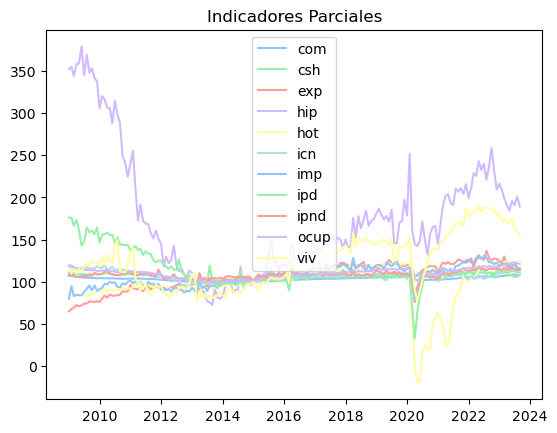

In [20]:
#Representamos resultados:
for n in nombres:
    plt.plot(ip_e[n], label=n)
    plt.title("Indicadores Parciales")
    plt.legend()

## 2.5. Creamos índice sintético

In [21]:
# Creamos índice sintético del consumo para España (ISC_e)
ISC_e = pd.Series()

for n in nombres:
    ISC_e = corr_esp[n] * ip_e[n]

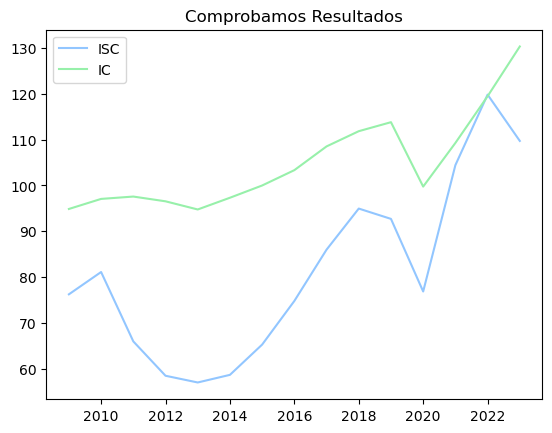

In [22]:
#Comprobamos resultado:
ISCa_e=ISC_e.resample("A", label="right").mean().set_axis(consf.index, axis=0)
Ca_e=consf["esp"]/consf["esp"].loc[2015]*100

plt.plot(ISCa_e, label="ISC")
plt.plot(Ca_e, label="IC")
plt.title("Comprobamos Resultados")
plt.legend()

# 3. Aragón 

## 3.1. Anualizamos datos

In [23]:
#nombres = ["com", "csh", "exp", "hip", "hot", "icn", "imp", "ipd", "ipnd", "ocup", "viv"]

# Almacenamos las series en una lista
x_a = [com["ara_des"], cshm["ara_des"], exp["ara_des"], hip["ara_des"], hot["ara_des"], icn["ara_des"], imp["ara_des"], ipd["ara_des"], ipnd["ara_des"], ocupm["ara_des"], viv["ara_des"]]

# Creamos un diccionario con las series y sus respectivos nombres
ara = dict(zip(nombres, x_a))

#Anualizamos datos para tener mismo índice:
a_a = {}

for n in nombres:
    a_a[n] = ara[n].resample("A", label="right").mean().set_axis(consf.index, axis=0)

## 3.2.  Calculamos tasas de variación

In [24]:
#Variables explicativas:
tv_a={}

for n in nombres:
    tv_a[n] = a_a[n]/a_a[n].shift(1) - 1
    
#Variable explicada:
ca_tv = consf["ara"] / consf["ara"].shift(1) - 1

In [25]:
#Comprobamos si hemos creado bien icn:
p=icn["ara_des"].resample("A", label="right").mean().set_axis(consf.index, axis=0)
ej=p/p.shift(1) - 1
ej=ej-tv_a["icn"]
ej

2009    NaN
2010    0.0
2011    0.0
2012    0.0
2013    0.0
2014    0.0
2015    0.0
2016    0.0
2017    0.0
2018    0.0
2019    0.0
2020    0.0
2021    0.0
2022    0.0
2023    0.0
Name: ara_des, dtype: float64

## 3.3. Calculamos pesos

In [26]:
corr_ara={}

for n in nombres:
    corr_ara[n] = np.corrcoef(ca_tv.loc["2010":], tv_a[n].loc["2010":])[0, 1]
    print(f"Correlación entre {n}-consumo en Aragón: {corr_ara[n]}")

Correlación entre com-consumo en Aragón: 0.35725555278857546
Correlación entre csh-consumo en Aragón: 0.5197844403943889
Correlación entre exp-consumo en Aragón: 0.5857951610049489
Correlación entre hip-consumo en Aragón: 0.2168326116643093
Correlación entre hot-consumo en Aragón: 0.8745129372000819
Correlación entre icn-consumo en Aragón: 0.3187465672081443
Correlación entre imp-consumo en Aragón: 0.7791953070443021
Correlación entre ipd-consumo en Aragón: 0.2167842951663796
Correlación entre ipnd-consumo en Aragón: 0.6530200687435863
Correlación entre ocup-consumo en Aragón: 0.5885362695067033
Correlación entre viv-consumo en Aragón: 0.44680023763052806


In [27]:
#Comprobamos correcta especificación de las ponderaciones:
corr_com={}

for n in nombres:
    corr_com[n]=corr_ara[n]/sum(corr_ara.values())

print(sum(corr_com.values()))

0.9999999999999999


## 3.4. Creamos índices parciales

In [28]:
# Creamos índices con base en 2015-01-01
ip_a = {}

for i, n in enumerate(nombres):
    ip_a[n] = x_a[i] / x_a[i].loc["2015-01-01"] * 100
    
ip_a

{'com': fecha
 2009-01-01    109.768132
 2009-02-01    109.149307
 2009-03-01    109.059562
 2009-04-01    108.671614
 2009-05-01    107.697628
                  ...    
 2023-05-01    106.681801
 2023-06-01    106.830928
 2023-07-01    106.578249
 2023-08-01    106.643470
 2023-09-01    105.646020
 Name: ara_des, Length: 177, dtype: float64,
 'csh': fecha
 2009-01-01    104.666939
 2009-02-01    104.437707
 2009-03-01    104.352768
 2009-04-01    103.743538
 2009-05-01    103.256180
                  ...    
 2023-05-01    102.997399
 2023-06-01    103.028160
 2023-07-01    103.076562
 2023-08-01    103.079768
 2023-09-01    102.328103
 Name: ara_des, Length: 177, dtype: float64,
 'exp': fecha
 2009-01-01     36.727815
 2009-02-01     63.963163
 2009-03-01     79.995039
 2009-04-01     70.537226
 2009-05-01     66.948102
                  ...    
 2023-05-01    155.538655
 2023-06-01    162.659437
 2023-07-01    198.853158
 2023-08-01    148.874768
 2023-09-01    180.532139
 Name: ara

In [29]:
#Comprobamos resultados:
p=hip["ara_des"]/hip["ara_des"].loc["2015-01-01"] * 100
p=p-ip_a["hip"]
p

fecha
2009-01-01    0.0
2009-02-01    0.0
2009-03-01    0.0
2009-04-01    0.0
2009-05-01    0.0
             ... 
2023-05-01    0.0
2023-06-01    0.0
2023-07-01    0.0
2023-08-01    0.0
2023-09-01    0.0
Name: ara_des, Length: 177, dtype: float64

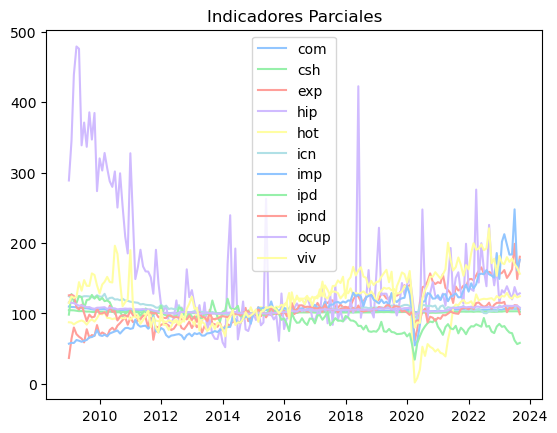

In [30]:
#Representamos resultados:
for n in nombres:
    plt.plot(ip_a[n], label=n)
    plt.title("Indicadores Parciales")
    plt.legend()

## 3.5. Creamos índice sintético

In [31]:
# Creamos índice sintético del consumo para España (ISC_e)
ISC_a = pd.Series()

for n in nombres:
    ISC_a = corr_ara[n] * ip_a[n]

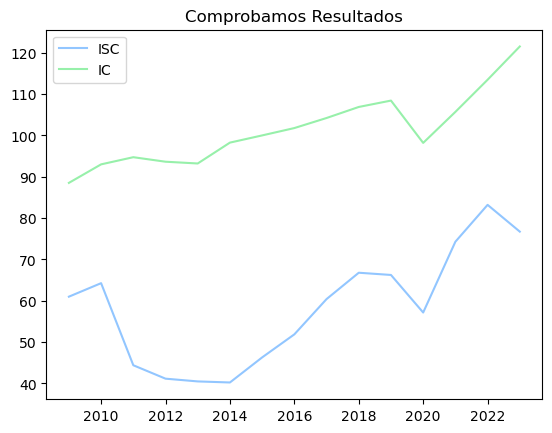

In [32]:
#Comprobamos resultado:
ISCa_a=ISC_a.resample("A", label="right").mean().set_axis(consf.index, axis=0)
Ca_a=consf["ara"]/consf["ara"].loc[2015]*100

plt.plot(ISCa_a, label="ISC")
plt.plot(Ca_a, label="IC")
plt.title("Comprobamos Resultados")
plt.legend()

# 4. RESPRESENTACIÓN GRÁFICA

In [33]:
#Ajustes previos:

#Ocupación hotelera:
hot_esp=a_e["hot"].loc["2017":"2023"]/a_e["hot"].loc[2015]*100
hot_ara=a_a["hot"].loc["2017":"2023"]/a_a["hot"].loc[2015]*100
v2 = {
    'Ocupación Hotelera': hot_esp,
    '': hot_ara,
}

#Producción Bienes no duraderos:
ipnd_esp=a_e["ipnd"].loc["2017":"2023"]/a_e["ipnd"].loc[2015]*100
ipnd_ara=a_a["ipnd"].loc["2017":"2023"]/a_a["ipnd"].loc[2015]*100

v3 = {
    'Prod. Bs. No Duraderos ': ipnd_esp,
    '': ipnd_ara,
}

#Indicador Sintético:
isc_esp=ISCa_e.loc["2017":"2023"]/ISCa_e.loc[2015]*100
isc_ara=ISCa_a.loc["2017":"2023"]/ISCa_a.loc[2015]*100

v4 = {
    'España': isc_esp,
    'Aragón': isc_ara,
}

#Exportaciones:
exp_ara=tv_a["exp"].loc["2017":"2023"]*100
exp_esp=tv_e["exp"].loc["2017":"2023"]*100


#Importaciones:
imp_ara=tv_a["imp"].loc["2017":"2023"]*100
imp_esp=tv_e["imp"].loc["2017":"2023"]*100

#Balanza Comercial:
bc=pd.read_excel("bc.xlsx")
bc.set_index("fecha", inplace=True)
bc=bc.loc["2009-01-01":"2023-09-01"]
bc=bc.resample("Q", label="right").mean().set_index(csh.index)
bc=bc/1000 #Millones de euros

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13436\1522226565.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1=plt.subplot2grid(gridsize,(0,0),colspan=100,rowspan=5)


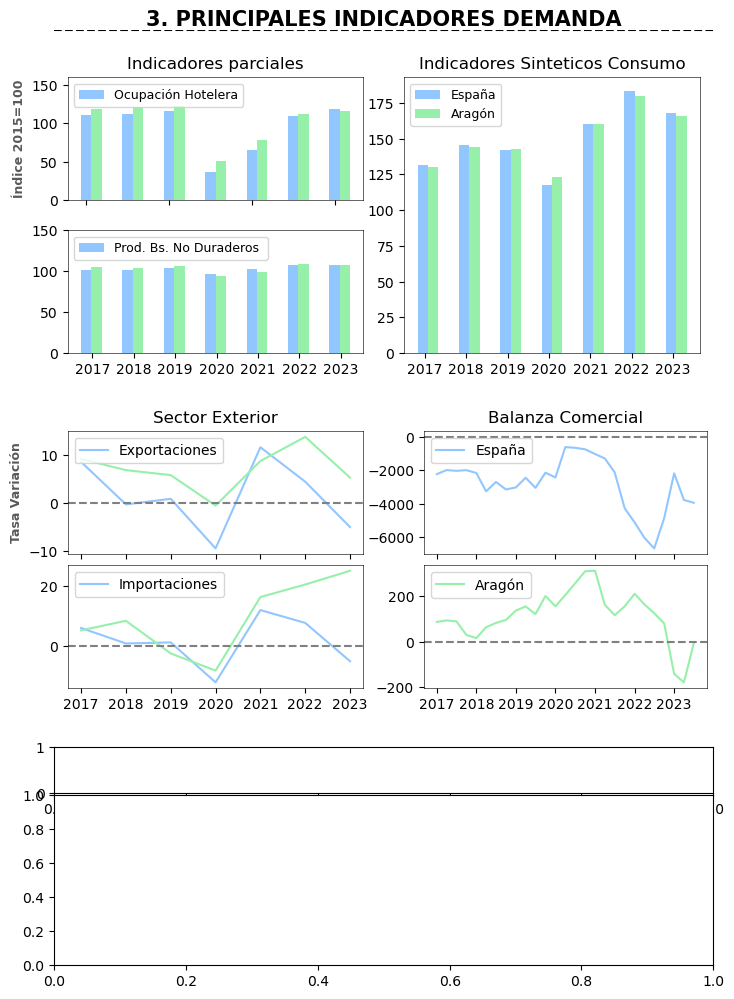

In [34]:
#Creamos primera página de mercado de trabajo:
gridsize=(100,100)
fig_size=(8.5,12.4)

fig,ax=plt.subplots(figsize=fig_size,dpi=100)

ce= "#92C6FF"
ca="#97F0AA"

años=('2017', '2018', '2019', '2020', '2021', '2022', '2023')
x = np.arange(len(años))  # las ubicaciones de las etiquetas
ancho = 0.25  # el ancho de las barras
multiplicador = 0


#Titulo:
ax1=plt.subplot2grid(gridsize,(0,0),colspan=100,rowspan=5)
text = "3. PRINCIPALES INDICADORES DEMANDA"
ax1.set_title(text, weight="bold", size=15, va="center")
ax1.axhline(1,0, color='black', linestyle='--')
ax1.axis("Off")


#Ocupación hotelera:
ax2=plt.subplot2grid(gridsize,(5,2), colspan=45, rowspan=13)

## Itera sobre valores
for atributo, medida in v2.items():
    desplazamiento = ancho * multiplicador
    barras = ax2.bar(x + desplazamiento, medida, ancho, label=atributo)
    multiplicador += 1

## Agrega texto para etiquetas, título y etiquetas personalizadas del eje x, etc.
ax2.set_ylabel('Índice 2015=100', size=9, weight="bold", alpha=0.65)
ax2.set_title('Indicadores parciales')
ax2.set_xticklabels([])
ax2.legend(loc='upper left', fontsize=9)
ax2.set_ylim(0, 160)
for axis in ['top', 'bottom', 'left', 'right']:
    ax2.spines[axis].set_linewidth(0.65)  
    ax2.spines[axis].set_alpha(0.65)


# Producción de Bienes no duraderos
ax3=plt.subplot2grid(gridsize,(21,2), colspan=45, rowspan=13)

for atributo, medida in v3.items():
    desplazamiento = ancho * multiplicador
    barras = ax3.bar(x + desplazamiento, medida, ancho, label=atributo)
    multiplicador += 1

ax3.set_xticks(x + ancho+0.4, años)
ax3.legend(loc='upper left', ncols=1, fontsize=9)
ax3.set_ylim(0, 150)

for axis in ['top', 'bottom', 'left', 'right']:
    ax3.spines[axis].set_linewidth(0.65)  
    ax3.spines[axis].set_alpha(0.65)

# Indicadores sintéticos
ax4=plt.subplot2grid(gridsize,(5,53), colspan=45, rowspan=29)

for atributo, medida in v4.items():
    desplazamiento = ancho * multiplicador
    barras = ax4.bar(x + desplazamiento, medida, ancho, label=atributo)
    multiplicador += 1

ax4.set_xticks(x + ancho+0.8, años)
ax4.legend(loc='upper left', fontsize=9)
ax4.set_title('Indicadores Sinteticos Consumo')

for axis in ['top', 'bottom', 'left', 'right']:
    ax4.spines[axis].set_linewidth(0.65)  
    ax4.spines[axis].set_alpha(0.65)

# Exportaciones
ax5=plt.subplot2grid(gridsize,(42,2), colspan=45, rowspan=13)

ax5.plot(exp_esp.loc["2017":"2023-09-30 "], color=ce, label="Exportaciones")
ax5.plot(exp_ara.loc["2017":"2023-09-30 "], color=ca)

for axis in ['top', 'bottom', 'left', 'right']:
    ax5.spines[axis].set_linewidth(0.65)  
    ax5.spines[axis].set_alpha(0.65)

ax5.legend(loc='upper left')
ax5.set_title("Sector Exterior")
ax5.set_xticklabels([])
ax5.axhline(0, color='grey', linestyle='--')
ax5.set_ylabel('Tasa Variación', size=9, weight="bold", alpha=0.65)

#Importaciones
ax6=plt.subplot2grid(gridsize,(56,2), colspan=45, rowspan=13)

ax6.plot(imp_esp.loc["2017":"2023"], color=ce, label="Importaciones")
ax6.plot(imp_ara.loc["2017":"2023"], color=ca)

for axis in ['top', 'bottom', 'left', 'right']:
    ax6.spines[axis].set_linewidth(0.65)  
    ax6.spines[axis].set_alpha(0.65)
ax6.axhline(0, color='grey', linestyle='--')
ax6.legend(loc='upper left')


#Balanza Comercial España
ax7=plt.subplot2grid(gridsize,(42,56), colspan=43, rowspan=13)

ax7.plot(bc["esp_des"].loc["2017":"2023"], color=ce, label="España")

for axis in ['top', 'bottom', 'left', 'right']:
    ax7.spines[axis].set_linewidth(0.65)  
    ax7.spines[axis].set_alpha(0.65)

ax7.legend(loc='upper left')
ax7.set_title("Balanza Comercial")
ax7.set_xticklabels([])
ax7.axhline(0, color='grey', linestyle='--')
#ax7.set_ylabel('Tasa Variación', size=9, weight="bold", alpha=0.65)


#Balanza Comercial Aragón
ax8=plt.subplot2grid(gridsize,(56,56), colspan=43, rowspan=13)

ax8.plot(bc["ara_des"].loc["2017":"2023"], color=ca, label="Aragón")

for axis in ['top', 'bottom', 'left', 'right']:
    ax8.spines[axis].set_linewidth(0.65)  
    ax8.spines[axis].set_alpha(0.65)

ax8.legend(loc='upper left')
ax8.axhline(0, color='grey', linestyle='--')

plt.savefig("Demanda.pdf", format="pdf")
plt.show()